In [11]:
# Basic
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Save/load
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# 🔍 Load dataset
data_path = r"C:\Users\divye\Downloads\titanic.csv"
df = pd.read_csv(data_path)

print("✅ Data loaded. Shape:", df.shape)
df.head()

✅ Data loaded. Shape: (418, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


=== Data Types & Non-Null Counts ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB

=== Missing Values ===


,Missing,Percent (%)
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
PassengerId,0,0.00
Name,0,0.00
Pclass,0,0.00
Survived,0,0.00
Sex,0,0.00
Parch,0,0.00
SibSp,0,0.00



=== Survival Distribution ===
Not Survived (0): 266 (63.6%)
Survived (1): 152 (36.4%)


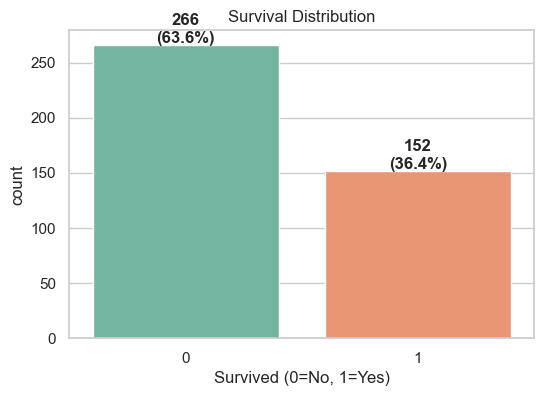

In [13]:
# === INFO ===
print("=== Data Types & Non-Null Counts ===")
df.info()

# === MISSING VALUES ===
print("\n=== Missing Values ===")
missing = df.isnull().sum()
pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent (%)': pct}).sort_values('Missing', ascending=False)
display(missing_df)

# === TARGET BALANCE ===
print("\n=== Survival Distribution ===")
counts = df['Survived'].value_counts()
pct_surv = counts / len(df) * 100
for i in [0, 1]:
    label = 'Not Survived' if i == 0 else 'Survived'
    print(f"{label} ({i}): {counts[i]} ({pct_surv[i]:.1f}%)")

# Plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Survived', palette='Set2')
for i, v in enumerate(counts):
    plt.text(i, v + 2, f'{v}\n({pct_surv[i]:.1f}%)', ha='center', fontweight='bold')
plt.title('Survival Distribution')
plt.xlabel('Survived (0=No, 1=Yes)')
plt.show()

In [14]:
# 🔧 Define features
target = 'Survived'
features = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', target])
y = df[target]

# Define column types
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', sparse_output=False))
        ]), categorical_cols)
    ],
    remainder='drop'  # Ignore any extra columns
)

# Fit & transform
X_processed = preprocessor.fit_transform(features)
feature_names = (
    numerical_cols +
    preprocessor.named_transformers_['cat']['encoder']
    .get_feature_names_out(categorical_cols).tolist()
)

X_processed = pd.DataFrame(X_processed, columns=feature_names)

print("✅ Preprocessing complete.")
print("Final shape:", X_processed.shape)
print("Features:", list(feature_names))
print("Any NaN? →", X_processed.isnull().sum().sum())

✅ Preprocessing complete.
Final shape: (418, 9)
Features: ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S']
Any NaN? → 0


In [15]:
# Split first (before scaling to avoid leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# Build full pipeline: scaling + model
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train
pipeline.fit(X_train, y_train)

print("✅ Model trained.")

Train size: (334, 9) | Test size: (84, 9)
✅ Model trained.


🎯 Accuracy: 1.0000 (100.00%)
📈 ROC AUC:  1.0000

📝 Classification Report:
              precision    recall  f1-score   support

Not Survived       1.00      1.00      1.00        53
    Survived       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



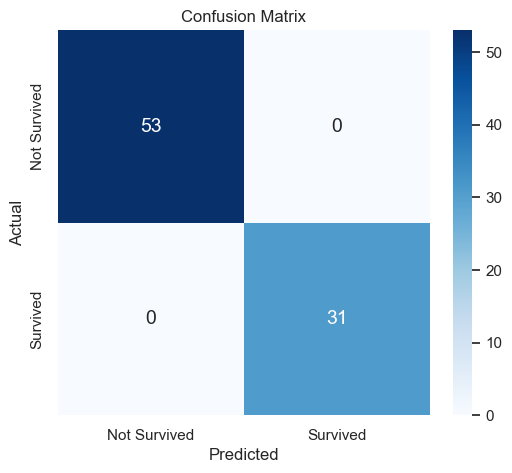

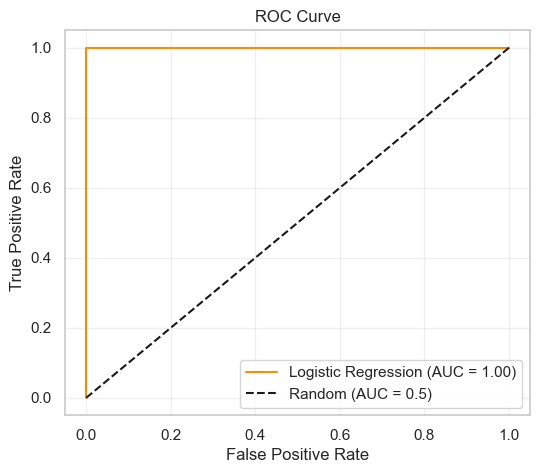

In [16]:
# Predict
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"🎯 Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"📈 ROC AUC:  {auc:.4f}")

print("\n📝 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived']))

# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'],
            annot_kws={'size':14})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
plt.figure(figsize=(6,5))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
# Save the full pipeline (includes imputation + scaling + model)
joblib.dump(pipeline, 'titanic_pipeline.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')  # if you want separate control
joblib.dump(feature_names, 'feature_names.pkl')

print("✅ Pipeline saved as 'titanic_pipeline.pkl'")
print("✅ Use this in Streamlit with pipeline.predict([<list>])")

✅ Pipeline saved as 'titanic_pipeline.pkl'
✅ Use this in Streamlit with pipeline.predict([<list>])
